In [17]:
import torch
from circuits import Circuit,Kinds
from learn import Trainer
from data import Data

In [18]:
# Get cpu or gpu device for training.
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

# torch.autograd.set_detect_anomaly(True)
torch.set_printoptions(precision=13, linewidth=200)

Using cpu device


[(IVS, 1000, 0), (R, 1, 0), (R, 2, 1), (R, 3, 2), (R, 4, 3), (R, 5, 4), (R, 6, 5), (R, 7, 6), (R, 8, 7), (R, 9, 8), (R, 10, 9), (R, 11, 10), (R, 12, 11), (R, 13, 12), (R, 14, 13), (R, 15, 14), (R, 16, 15), (R, 17, 16), (R, 18, 17), (R, 19, 18), (R, 20, 19), (R, 21, 20), (R, 22, 21), (R, 23, 22), (R, 24, 23), (R, 25, 24), (R, 26, 25), (R, 27, 26), (R, 28, 27), (R, 29, 28), (R, 30, 29), (R, 31, 30), (R, 32, 31), (R, 33, 32), (R, 34, 33), (R, 35, 34), (R, 36, 35), (R, 37, 36), (R, 38, 37), (R, 39, 38), (R, 40, 39), (R, 41, 40), (R, 42, 41), (R, 43, 42), (R, 44, 43), (R, 45, 44), (R, 46, 45), (R, 47, 46), (R, 48, 47), (R, 49, 48), (R, 50, 49), (R, 51, 50), (R, 52, 51), (R, 53, 52), (R, 54, 53), (R, 55, 54), (R, 56, 55), (R, 57, 56), (R, 58, 57), (R, 59, 58), (R, 60, 59), (R, 61, 60), (R, 62, 61), (R, 63, 62), (R, 64, 63), (R, 65, 64), (R, 66, 65), (R, 67, 66), (R, 68, 67), (R, 69, 68), (R, 70, 69), (R, 71, 70), (R, 72, 71), (R, 73, 72), (R, 74, 73), (R, 75, 74), (R, 76, 75), (R, 77, 76), (

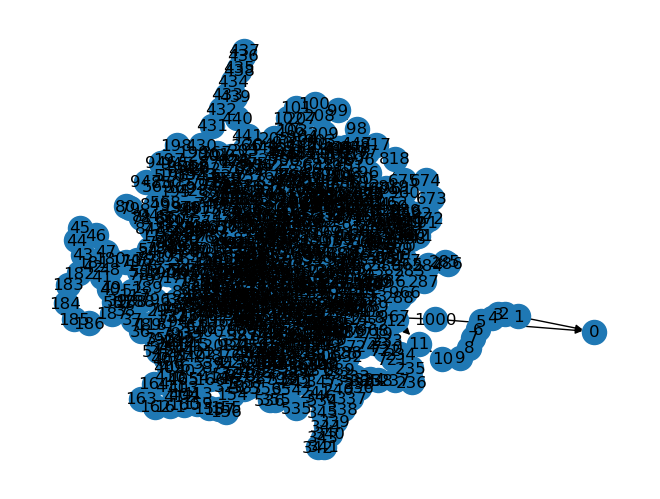

In [19]:
c = Circuit()
c.ring(Kinds.IVS,Kinds.R,1000)
c.elements[0].attr = 1
c.elements[-1].v = 1e-6
print(c.elements)
c.draw()

In [20]:
data = Data(c)
trainer = Trainer(data, 1e-1)

In [21]:
stable_threshold = 1e-3
i_sol,v_sol,a_sol,loss,epoch = trainer.run(1000, stable_threshold)
c.load(i_sol,v_sol,a_sol)
i_sol[-1],v_sol[-1],a_sol[-1],epoch,loss

threshold met
reset_count = 8


(tensor(0.0009780202527),
 tensor(9.9999999747524e-07),
 tensor(0.0010224736761, grad_fn=<SelectBackward0>),
 17,
 tensor(4.9999999800210e-13, grad_fn=<MseLossBackward0>))